<a href="https://colab.research.google.com/github/jbloewencolon/Psychedelic-Trip-Generator/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling for a Psychedelic Trip Generator

![tree machine.png](https://github.com/jbloewencolon/Psychedelic-Trip-Generator/blob/main/Images/trip%20generator%201.png)

By Jordan Loewen-Colón August 2023

### Objective

In March 2022, researchers from McGill University embarked on a [groundbreaking project](https://www.mcgill.ca/neuro/channels/news/largest-ever-psychedelics-study-maps-changes-conscious-awareness-neurotransmitter-systems-338389) using descriptions from personal experiences with psychedelic substances to map specific mental states to brain activity. This study laid the foundation for developing a sophisticated technology tool that may predict which areas of the brain should be activated to create particular mental sensations or feelings.

This research aims to contribute to **discovering new medicines** by understanding how different drugs can affect the mind. However, a major challenge in this area is the **scarcity** of firsthand accounts or personal descriptions of these experiences.

To address this gap, our objective is to leverage existing personal narratives and use artificial intelligence (AI) to **create realistic 'trip reports'** categorized by different types of drugs. These AI-generated descriptions will then be used to **enhance future research** in the exciting and evolving field of psychedelics, potentially leading to **innovative therapeutic applications**.

### Insights

### Data Understanding

Our data was collected using a data transfer agreement with McGill University and Queen’s University. The data itself is from Erowid’s experience vaults and is subject to their copyright and may only be used with their permission.

The raw data set contains nearly 40k drug reports with 11743 unique drug types. No identifying information was gathered other than the metadata, including dosage, delivery method, the weight of the individual, year consumed, and gender.

Reports themselves averaged between 3k and 5k wong word frequency.

## Data Cleaning:

To prepare our data, we performed the following steps:


**Cleaning:**

- Dropping of Null and NaN values
- Dropping non-English reports
- Dropping reports with less than five words
- Dropping drugs with a single occurrence

**Feature Engineering:**

- Processing the reports into a new column using lemmatization, tokenization, and lowercasing the text
- Creating a new column to indicate whether or not a report contained multiple drug labels
- Creating a new report copy for each individual drug listed in a report
- Cleaning and categorizing drugs into 10 drug categories: Psychedelic, Pharmaceutical, Cannabinoid, Other, Stimulant, Entactogen/Empathogen, Dissociative, Depressant, Opioid, Entheogen
- Doubling reports that were not mixed to add weight to "pure" drug reports

**---**

Please check out the file [here](https://github.com/jbloewencolon/Psychedelic-Trip-Generator/blob/main/Sandbox/Data%20Cleaning.ipynb) to view the data cleaning and engineering process.

## Data Modeling:
With our cleaned data in hand, we now want to train some models on our data set. In particular, we want to see how well they can predict drug categories based on the processed reports. Precision will be our metric, as we want a model that is able to reproduce similar reports itself.

### Step 1: Importing Libraries
This section is about loading all the necessary libraries to conduct the project.

General Libraries like itertools and re for general programming tasks.
Natural Language Processing Libraries such as nltk and gensim for text processing and modeling.
Machine Learning Libraries like sklearn, tensorflow, xgboost for building, training, and evaluating models.
Data Handling Libraries like numpy, pandas for managing and manipulating data.
Visualization Libraries such as matplotlib, seaborn for creating plots.
Imbalanced Learning Library imblearn to handle imbalanced datasets.
Word Cloud Library wordcloud for visualizing word frequency.

In [11]:
!pip install numpy --upgrade
!pip install lime

import itertools
import re
from ast import literal_eval
import pickle
import gensim
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import random
import joblib
from joblib import dump
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from wordcloud import WordCloud
from xgboost import XGBClassifier
from lime.lime_text import LimeTextExplainer
from collections import Counter, OrderedDict

### Step 2: Data Loading and Preprocessing
This part loads the dataset and provides information about its structure


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/vectorized.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67875 entries, 0 to 67874
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             67875 non-null  int64 
 1   drug                   67875 non-null  object
 2   dosage                 66103 non-null  object
 3   delivery               65447 non-null  object
 4   weight                 67875 non-null  int64 
 5   gender                 67875 non-null  object
 6   report                 67875 non-null  object
 7   processed_report       67875 non-null  object
 8   mixed                  67875 non-null  int64 
 9   drug_category          67875 non-null  object
 10  vectorized_reports     67875 non-null  object
 11  processed_report_list  67875 non-null  object
dtypes: int64(3), object(9)
memory usage: 6.2+ MB


In [ ]:
df.head()

,Unnamed: 0,drug,dosage,delivery,weight,gender,report,processed_report,mixed,drug_category
0,0,mdpv,NaN,insufflated,140,male,"MDPV, Over a Two-Month PeriodI thought I'd sha...","['mdpv', 'over', 'a', 'twomonth', 'periodi', '...",1,Entactogen/Empathogen
1,1,crack,repeated,smoked,165,male,I'll start this story with a bit of background...,"['i', 'll', 'start', 'this', 'story', 'with', ...",0,Stimulant
2,2,methcathinone,10 mg,IV,135,male,I hate the name of this drug. Impossible for m...,"['i', 'hate', 'the', 'name', 'of', 'this', 'dr...",1,Stimulant
3,3,jwh-018,,smoked,209,male,"Me - Male (95kg, 29 y/o, moderate experience o...","['me', 'male', '95kg', '29', 'yo', 'moderate',...",1,Cannabinoid
4,4,pharms - pregabalin,,,170,male,GBL AddictI was thinking of writing this for a...,"['gbl', 'addicti', 'wa', 'thinking', 'of', 'wr...",1,Pharmaceutical


Looks like our data was imported cleanly and has been randomized.

## Data Preperation for Models
Our goal is to train at least three models and that compare which achives the highest precision. Our three models are:
* a simple logistic regression
* a random forest classifier (RFC)
* a XGBoost model

### Baseline Models:

Before adding complexity, we begin with simple models that pull from the tokenized reports. We add a TF-IDF vectorizer to turn our models into an expression (numerical vectors) that our models can better more easily understand. Many machine learning models cannot directly handle text data. Transforming text into numerical vectors enables us to apply machine learning techniques to derive insights from written content.

In [ ]:
# Define y
y = df['drug_category']

# Encode the labels in y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define X
X = df['processed_report']

In [ ]:
# Split data for all models
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [ ]:
# Define pipeline for Logistic Regression with TF-IDF
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None)), # Change here
    ('clf', LogisticRegression(max_iter=500, C=1.0, solver='saga', n_jobs=-1))
])

# Define pipeline for RFC with TF-IDF
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None)), # Change here
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1))
])

# Define pipeline for XGB with TF-IDF
pipeline_xgb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None)), # Change here
    ('clf', XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1, eval_metric='mlogloss'))
])

In [ ]:
# List of models with names
models = [
    ("Logistic Regression", pipeline_lr),
    ("Random Forest", pipeline_rf),
    ("XGBoost", pipeline_xgb),
]

def train_and_predict(pipeline, X_train, y_train, X_test):
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    return pipeline.predict(X_train), pipeline.predict(X_test)

def compare_results(model_name, y_train, y_train_pred, y_test, y_test_pred, label_encoder):
    target_names = label_encoder.classes_
    print(f"\n{model_name} - Train Classification Report:")
    print(classification_report(y_train, y_train_pred, target_names=target_names, zero_division=1))
    print(f"{model_name} - Test Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=target_names, zero_division=1))

for model_name, model in models:
    y_train_pred, y_test_pred = train_and_predict(model, X_train, y_train, X_test)
    compare_results(model_name, y_train, y_train_pred, y_test, y_test_pred, label_encoder)


Logistic Regression - Train Classification Report:
                       precision    recall  f1-score   support

          Cannabinoid       0.68      0.37      0.48      4622
           Depressant       0.72      0.33      0.45      1809
         Dissociative       0.75      0.61      0.67      2116
Entactogen/Empathogen       0.78      0.81      0.80      5166
            Entheogen       0.82      0.70      0.76      2814
               Opioid       0.77      0.72      0.75      1967
                Other       0.81      0.64      0.72      4999
       Pharmaceutical       0.77      0.74      0.76      5231
          Psychedelic       0.77      0.97      0.86     22690
            Stimulant       0.79      0.62      0.70      2886

             accuracy                           0.77     54300
            macro avg       0.77      0.65      0.69     54300
         weighted avg       0.77      0.77      0.76     54300

Logistic Regression - Test Classification Report:
             

The category we are most interested in a Psychedelics. And since we were targeting precision, it looks like our logestic regression performed best on the test set and our RFC performed best on the training set, which indicates overfitting. Let's see if we can improve our RFC and XGB models with Word2Vec before choosing one for hyperparameter tuning.

#### Creating a Word2Vec Vectorizer

Word2Vec models are useful in more complex multi-classification problems. Imagine the words in psychedelic trip reports are like ingredients in a complex recipe. Word2Vec helps translate these words into a language that a computer, such as a Random Forest Classifier (RFC), understands. It’s like having a taste expert who knows the flavor of each ingredient (Word2Vec) working with a skilled chef (RFC) to create a dish. Together, they recognize unique flavors and combinations in trip reports, allowing us to identify specific experiences or drug categories more accurately.

In [3]:
# Function to convert a report into a vector
def report_to_vector(report, model):
    report_vec = np.zeros(model.vector_size)
    numw = 0
    for word in report:
        try:
            report_vec = np.add(report_vec, model.wv[word])
            numw += 1
        except:
            pass
    return report_vec / numw if numw != 0 else np.zeros(model.vector_size)

class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.size = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return vectorize_reports(X, self.model)

### Tokenizing Reports and then Training the Model
By breaking the text down into individual words or "tokens", we can analyze the frequency and relationships between words within the reports. Then training our Word2Vec to capture the semantic meanings of words allows us to analyze and compare reports based on their content.

In [4]:
tokenized_reports = [report.split() for report in df['processed_report'].tolist()]

# Train a Word2Vec model
word2vec = Word2Vec(sentences=tokenized_reports, vector_size=100, window=5, min_count=5, workers=4)

### Converting Reports to Vectors
This function takes the tokenized reports and the trained Word2Vec model to convert each report into a numerical vector. Transforming the text into numerical format allows us to analyze and model the reports using statistical and machine learning techniques.

In [5]:
def vectorize_reports(tokenized_reports, word2vec_model):
    vectorized_reports = []
    for report in tokenized_reports:
        vectors = [word2vec_model.wv[word] for word in report if word in word2vec_model.wv]
        report_vec = np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)
        vectorized_reports.append(report_vec)
    return np.array(vectorized_reports)

X_word2vec = vectorize_reports(tokenized_reports, word2vec)
X_word2vec = np.vstack(X_word2vec)

### Visualizing the insights from the reports for 'Psychedelics':
In this step, we collect all the unique words that are related to the psychedelic category in our data. We then check the Word2Vec model using a clustering method (k-means) to see if there are patterns of similar meaningful words clustering together. Since we don't know the best number of clusters to search for, we'll use the elbow method. This technique involves plotting the explained variation as a function of the number of clusters, and picking the "elbow" of the curve as the number of clusters to use. It helps in finding an optimal number of clusters by fitting the model with a range of cluster values and selecting the one that gives the most meaningful segmentation without adding unnecessary complexity.

In [9]:
# Create a set of unique words related to the 'Psychedelic' category
unique_words = set()
psychedelic_reports = df[df['drug_category'] == 'Psychedelic']['processed_report']
for report in psychedelic_reports:
    for word in report.split():
        unique_words.add(word)

unique_words_list = list(unique_words)
word_vectors = [word2vec.wv[word] for word in unique_words if word in word2vec.wv]
word_vectors = np.array(word_vectors)

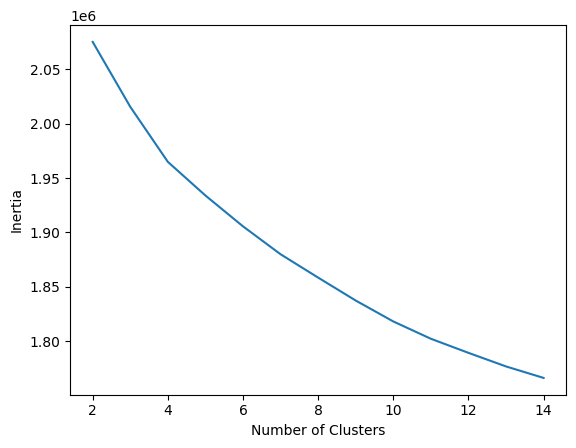

In [12]:
# Determine optimal number of clusters
inertia = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(word_vectors)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 15), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [14]:
# Pick the optimal number of clusters (where the elbow is)
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
clusters = kmeans.fit_predict(word_vectors)

It looks like the ideal amount of clusters is 7. Our next step starts by putting together two sets of information: the word vectors (which translate words into numbers that computers can understand) and the centers of the clusters (which are like the "average" points for groups of similar words). The code then applies a technique called t-SNE. This is like simplifying a big and complex map into a smaller one, so it's easier to see patterns. It takes those combined numbers and reduces them into just two dimensions, making it easier to visualize.

In [ ]:
# Concatenate word_vectors and cluster centers
combined_vectors = np.vstack([word_vectors, kmeans.cluster_centers_])

# Fit t-SNE on the combined vectors
reduced_tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
reduced_combined_vectors = reduced_tsne.fit_transform(combined_vectors)

# Separate reduced word vectors and reduced centroids
reduced_vectors = reduced_combined_vectors[:-n_clusters]
reduced_centroids = reduced_combined_vectors[-n_clusters:]

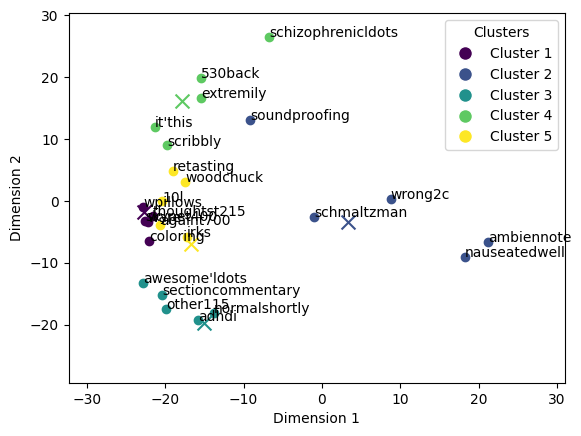

In [ ]:
# Initialize an empty scatter plot (to build the legend)
fig, ax = plt.subplots()

# Define a color map for clusters
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

# Loop through each cluster to plot the top words and build the legend
for cluster_number in range(n_clusters):
    for word in top_words_per_cluster[cluster_number]:
        idx = unique_words_list.index(word)
        # Scatter plot for the specific word
        ax.scatter(reduced_vectors[idx, 0], reduced_vectors[idx, 1], c=[colors[cluster_number]])
        plt.annotate(word, (reduced_vectors[idx, 0], reduced_vectors[idx, 1]))

    # Plot the centroid for the cluster
    ax.scatter(reduced_centroids[cluster_number, 0], reduced_centroids[cluster_number, 1], c=[colors[cluster_number]], marker='x', s=100)

# Shrink the axes length for more space
padding = 1
ax.set_xlim(reduced_vectors[:, 0].min() - padding, reduced_vectors[:, 0].max() + padding)
ax.set_ylim(reduced_vectors[:, 1].min() - padding, reduced_vectors[:, 1].max() + padding)

# Add labels for x and y axes
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')

# Create a legend for the clusters
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=f'Cluster {i+1}') for i in range(n_clusters)]
plt.legend(handles=legend_elements, title="Clusters")

plt.show()

We clearly have some different clusters here, but it is not clear what they might have in common. That's because our data set is so complex, and Word2Vec is relatively simply, but it's a positive sign that the clusters do seem to be clear! That means even our simple model is picking up on patterns.

Let's take a look at the words the model clustered together more closely:

In [15]:
# Create a mapping of words to their vectors
word_to_vec_mapping = {unique_words_list[i]: vec for i, vec in enumerate(word_vectors)}

# Find the top 5 most frequent words for each cluster
top_words_per_cluster = {}
for cluster_number in range(5):
    words_in_cluster = [unique_words_list[i] for i in range(len(word_vectors)) if clusters[i] == cluster_number]
    word_frequencies = Counter(words_in_cluster)
    top_5_words = [word for word, _ in word_frequencies.most_common(5)]
    top_words_per_cluster[cluster_number] = top_5_words

# Print the top 5 words for each cluster
for cluster_number, words in top_words_per_cluster.items():
    print(f"Cluster {cluster_number + 1}: {', '.join(words)}")

Cluster 1: unthreatening, trancey, opened700am, else1130, 666ug
Cluster 2: riba, fangled, thikal, expiernce, relaxedldots
Cluster 3: 504pm, definedall, scoobin, 30mg, decompressed
Cluster 4: sitterbrother, attacksfeeling, lifelesness, holer, firstset
Cluster 5: sycle, entityalien, endless139am, lester, ganjah


Again, it's not clear. In fact, some of these words look a bit noisy, which means they probably were missed during the data-cleaning step. Our model has given them more weight because of their relative rarity.

The next step sets our dependent and independent variables for our more complex models. Additionally, the target variable (drug_category) is given labels for visualization later. Lastly, since we will be using TF-IDF for our Logistic Regression, and Word2Vec for our RFC and XGB, we've split their X columns appropriately.

#### Defining New Pipelines
We're focusing on our RFC and XGBoost to see if we can get improvements. We will start again with pipelines, and this time, because of our class imbalance (there are way more reports in the "Psychedelic" category), we will include SMOTE for each and have them focus on the vectorizations produced by our Word2Vec model.

In [ ]:
# Define pipeline for RFC with SMOTE
pipeline_rf = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto')),  # Add SMOTE for oversampling
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1))
])

# Define pipeline for XGB with SMOTE
pipeline_xgb = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto')),  # Add SMOTE for oversampling
    ('clf', XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1, eval_metric='mlogloss'))
])


In [ ]:
# Split and stratify data for RFC and XGB
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(X_word2vec, y_encoded))
X_train_w2v, X_test_w2v = X_word2vec[train_index], X_word2vec[test_index]
y_train_w2v, y_test_w2v = y_encoded[train_index], y_encoded[test_index]

### Training, Prediction, and Comparison
Here, we'll train the models, make predictions, and compare the results. This can be done by creating functions train_and_predict and compare_results.

In [ ]:
def train_and_predict(pipeline, X_train, y_train, X_test):
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predict on the train and test set
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    return y_train_pred, y_test_pred

def compare_results(model_name, y_train, y_train_pred, y_test, y_test_pred, label_encoder):
    target_names = label_encoder.classes_

    print(f"\n{model_name} - Train Classification Report:")
    print(classification_report(y_train, y_train_pred, target_names=target_names, zero_division=1))
    print(f"{model_name} - Test Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=target_names, zero_division=1))


In [ ]:
# Train and Predict for Random Forest (RFC)
y_train_pred_rf, y_test_pred_rf = train_and_predict(pipeline_rf, X_train_w2v, y_train_w2v, X_test_w2v)
compare_results("Random Forest", y_train_w2v, y_train_pred_rf, y_test_w2v, y_test_pred_rf, label_encoder)

# Train and Predict for XGBoost (XGB)
y_train_pred_xgb, y_test_pred_xgb = train_and_predict(pipeline_xgb, X_train_w2v, y_train_w2v, X_test_w2v)
compare_results("XGBoost", y_train_w2v, y_train_pred_xgb, y_test_w2v, y_test_pred_xgb, label_encoder)


Random Forest - Train Classification Report:
                       precision    recall  f1-score   support

          Cannabinoid       0.71      0.71      0.71      4622
           Depressant       0.67      0.74      0.70      1809
         Dissociative       0.80      0.87      0.83      2116
Entactogen/Empathogen       0.83      0.90      0.86      5166
            Entheogen       0.83      0.91      0.87      2814
               Opioid       0.85      0.88      0.86      1967
                Other       0.88      0.86      0.87      4999
       Pharmaceutical       0.85      0.85      0.85      5231
          Psychedelic       0.93      0.89      0.91     22690
            Stimulant       0.82      0.82      0.82      2886

             accuracy                           0.86     54300
            macro avg       0.82      0.84      0.83     54300
         weighted avg       0.86      0.86      0.86     54300

Random Forest - Test Classification Report:
                       pr

It looks like using Word2Vec vectors signifigantly improved both models precision for predicting Psychedelics. RFC improved by 11% from 68 to 79, and our XGB from 75 to 78. Our RFC model nudged the top spot by 1%, so we will use GridSearch CV to find the best parameters and then train and test our model with those:

In [ ]:
# Define the parameter grid
param_grid = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__bootstrap': [True, False]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5)

In [ ]:
# Perform grid search
grid_search.fit(X_train_w2v, y_train_w2v)

# Predict on the train and test set using the best model
y_train_pred_grid = grid_search.predict(X_train_w2v)
y_test_pred_grid = grid_search.predict(X_test_w2v)

In [ ]:
# Print the best parameters and the best score
print(grid_search.best_params_)
print(grid_search.best_score_)

# Generate and print the classification report for both train and test
print("Train Classification Report (with tuning):")
print(classification_report(y_train_w2v, y_train_pred_grid, zero_division=1))
print("Test Classification Report (with tuning):")
print(classification_report(y_test_w2v, y_test_pred_grid, zero_division=1))

Comparing the untuned results to the tuned results shows us that while the tuned results did better on the training data Psychedelic (93/94), they ended up doing worse on our test set (73/79). So we will stick with our untuned model to explore the results. It's also interesting to note that Psychedelics were the only category to improve. They had the most data, so perhaps our other models would improve as well if they had more data included in their reports.

### Exploratory Data Analysis
We'll start with a confusion matrix so we can get a sense of the particular ways that our model was succeeding and failing to make its predictions.

In [ ]:
# Label the categories
encoder = LabelEncoder()
encoder.fit(df['drug_category'])
drug_categories = encoder.classes_

# Generate confusion matrices for test
cm_test = confusion_matrix(y_test_w2v, y_test_pred_rf)

# Plot confusion matrix for test set
plt.figure(figsize=(12, 10))
sns.heatmap(cm_test, annot=True, xticklabels=drug_categories, yticklabels=drug_categories, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

It looks like our model was most likely to label a psychedelic as a cannabinoid or entactogen/empathogen, and least likely to label it a dissociative, opioid, or stimulant, which is what we would expect! Now let's check out some of the feature importances to see what it is our model thinks is valuable for making its predictions. We will use LIME (Local Interpretable Model-agnostic Explanations). LIME  is a technique that approximates a complex model's decisions with a simpler interpretable model, aiding in understanding individual predictions.

To do so, means we need to define a prediction probability function. This function should take a list of texts and return the predicted probabilities for each class for each text. It will use our Word2Vec model and our trained RFC pipeline.

In [ ]:
def preprocess_func(texts):
    transformed_texts = []
    for text in texts:
        processed_report = text.split() # Split the text into words
        # Collect vectors for words that exist in word2vec model
        vectors = [word2vec.wv[word] for word in processed_report if word in word2vec.wv]

        # If there are no vectors, use a zero vector instead
        if vectors:
            report_vec = np.mean(vectors, axis=0)
        else:
            report_vec = np.zeros(word2vec.vector_size)

        transformed_texts.append(report_vec)

    return np.vstack(transformed_texts)

def predict_proba_func(texts):
    transformed_texts = preprocess_func(texts)
    return pipeline_rf.predict_proba(transformed_texts)


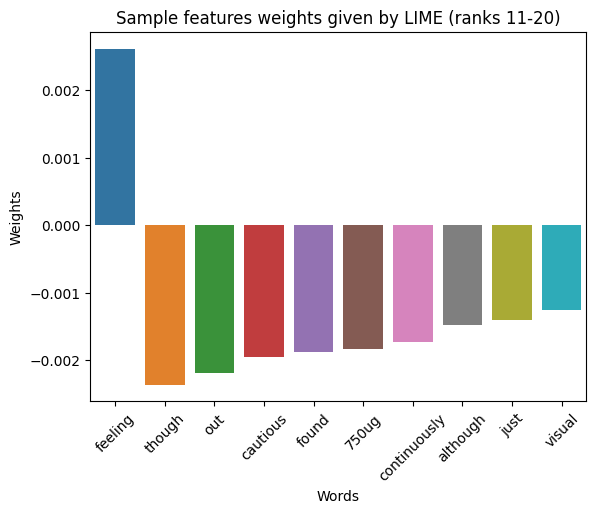

In [ ]:
# Filter the DataFrame to include only rows labeled as 'Psychedelic'
psychedelic_df = df[df['drug_category'] == 'Psychedelic']

# Select a random index from the filtered DataFrame
index_to_explain = randint(0, len(psychedelic_df['processed_report']) - 1)

# Get the processed report at the chosen index (this should be a string)
text_sample = psychedelic_df['processed_report'].iloc[index_to_explain]

# Initialize a LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

# Pass the string to the explainer
explanation = explainer.explain_instance(text_sample, predict_proba_func, num_features=20) # Get top 20

# Convert explanation to DataFrame
weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

# Select ranks 11-20
lime_weights_next_top_10 = lime_weights.iloc[10:20]

# Plot the barplot
sns.barplot(x="words", y="weights", data=lime_weights_next_top_10)
plt.xticks(rotation=45)
plt.xlabel('Words') # Label for x-axis
plt.ylabel('Weights') # Label for y-axis
plt.title('Sample features weights given by LIME (ranks 11-20)')
plt.show()

In the above, we shifted back by 10 because the first words that initially appeared were all stop words that did not contribue much to our understanding of the underlying predictions, or what the RFC model gave weight to when making predictions. With the above visualization, we can see that the word "feeling" was given positive weight when making a prediction, which means that, when that word appeared, it was likelier to be a "Psychedelic" than not.

Next we create an explainer using LIME, then choose an instance to explain, and then have the model explain.

In [ ]:
# Initialize a LimeTextExplainer
explainer = LimeTextExplainer(class_names=label_encoder.classes_, split_expression=r'\W+') # Split by words

# Filter the DataFrame to include only rows labeled as 'Psychedelic'
psychedelic_df = df[df['drug_category'] == 'Psychedelic']

# Select a random index from the filtered DataFrame
index_to_explain = randint(0, len(psychedelic_df['processed_report']) - 1)

# Get the processed report at the chosen index (already a list of words)
instance = psychedelic_df['processed_report'].iloc[index_to_explain]

# Convert the processed report to a single string (if it's a list of words)
if isinstance(instance, list):
    instance_as_string = ' '.join(instance)
else:
    instance_as_string = instance

# Find the index of 'Psychedelic' in the classes
class_index_to_explain = list(label_encoder.classes_).index('Psychedelic')

# Explain the prediction for the chosen instance, focusing on the class_index_to_explain
explanation = explainer.explain_instance(instance_as_string, predict_proba_func, labels=[class_index_to_explain])

# Show the explanation in the notebook
explanation.show_in_notebook()

Unfortunately we cannot derive much from the LIME explanation as it seems to indicate that our model gave a lot of weight to stop words in making its predictions. This will recquire more analysis in the future, and perhaps some experiments with removing the stop words even if we lose semantic understanding for our GPT-2 Model later.

Next, let's visualize our positive predictions and false predictions. The three plots visualize model predictions related to psychedelics on a 2D plane. Plot 1 shows correct predictions, Plot 2 highlights incorrect ones with red 'x' markers, and Plot 3 contrasts correct (blue) and incorrect (red 'x') predictions. While the model cannot tell exactly what the patterns are that it is following, we can see that there are differences here that the model is picking up on.

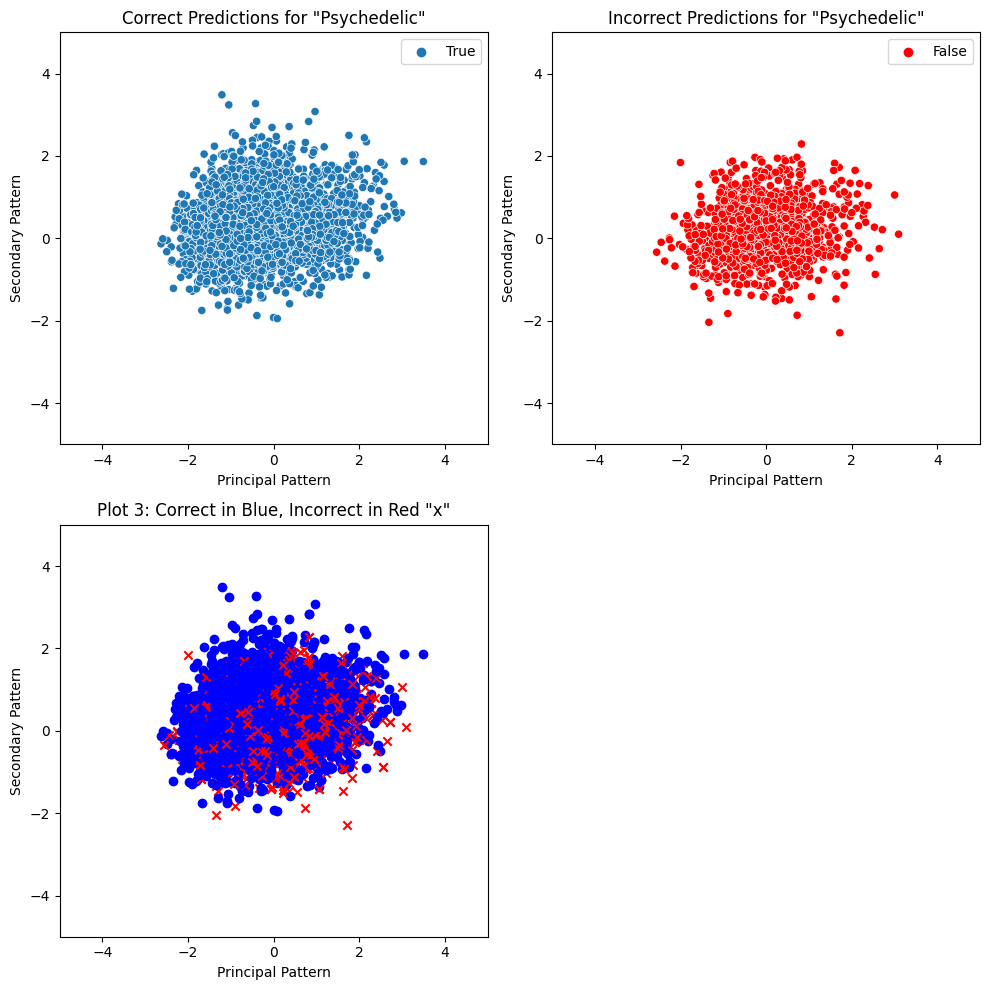

In [ ]:
plt.figure(figsize=(10, 10))

# Plot 1: Correct predictions for 'Psychedelic'
plt.subplot(2, 2, 1)
sns.scatterplot(x='Principal Pattern', y='Secondary Pattern', hue=(correct_predictions_df['true'] == correct_predictions_df['predicted']), data=correct_predictions_df)
plt.title('Correct Predictions for "Psychedelic"')
plt.xlim([-5, 5])
plt.ylim([-5, 5])

# Plot 2: Incorrect predictions for 'Psychedelic', with red color and 'x' markers
plt.subplot(2, 2, 2)
sns.scatterplot(x='Principal Pattern', y='Secondary Pattern', hue=(incorrect_predictions_df['true'] == incorrect_predictions_df['predicted']), data=incorrect_predictions_df, markers={False: 'x', True: 'o'}, palette={True: 'red', False: 'red'})
plt.title('Incorrect Predictions for "Psychedelic"')
plt.xlim([-5, 5])
plt.ylim([-5, 5])

# Plot 3: Positives in blue, negatives in red with 'x' markers
plt.subplot(2, 2, 3)
for true, predicted, x, y in zip(error_analysis_df['true'], error_analysis_df['predicted'], error_analysis_df['Principal Pattern'], error_analysis_df['Secondary Pattern']):
    color = 'blue' if true == predicted else 'red'
    marker = 'o' if true == predicted else 'x'
    plt.scatter(x, y, color=color, marker=marker)
plt.title('Plot 3: Correct in Blue, Incorrect in Red "x"')
plt.xlabel('Principal Pattern')
plt.ylabel('Secondary Pattern')
plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.tight_layout()
plt.show()

Finally, let's end with measureing a MAtthews Correlation Coefficent and finding the Balanaced Accuracy Score:

In [ ]:
mcc = matthews_corrcoef(y_test, y_test_pred_rf)
balanced_acc = balanced_accuracy_score(y_test, y_test_pred_rf)

print("Matthews correlation coefficient:", mcc)
print("Balanced accuracy score:", balanced_acc)


Matthews correlation coefficient: 0.5456515693581735
Balanced accuracy score: 0.558826819250298


1. **Matthews Correlation Coefficient (MCC):** A value of 0.5457 is a moderate positive value, suggesting that there is a reasonably good correlation between the predicted values and the actual values for the 'Psychedelic' class. This indicates that our model is performing better than random guessing but might still have room for improvement.

2. **Balanced Accuracy Score:** A value of 0.5588 is slightly above the midpoint of 0.5, indicating that the model's performance is better than random guessing but still somewhat close to it. Balanced accuracy considers the performance across all classes, taking into account imbalances, so this suggests that there might be certain classes that the model is struggling with more than others.

These results suggest that our model has some predictive power but could likely benefit from further tuning and optimization. If we had more time, we could experiment with different preprocessing techniques, feature engineering, hyperparameter tuning, or even trying different algorithms.

## Conclusion

From our analysis, the key insights include:

Significance of "Feeling": The word "feeling" was found to have a positive weight in the Random Forest Classifier model, making it likely to classify a report as a psychedelic experience.

Improvement with Larger Data Sample for Psychedelics: Word2Vec improved the precision in predicting Psychedelics with RFC by 11%. More data in other categories could lead to similar enhancements.

Underlying Patterns in Predictions: Visualization revealed differences in positive and negative predictions related to psychedelics, indicative of how the model made its false positives.

We also employed an LDA model to identify underlying themes. Topic 4 reflects existential themes; Topic 6 focuses on physical sensations; Topic 9 encapsulates social aspects; and Topic 10 illustrates visual experiences. The topics for Psychedelics and "Pharmaceuticals" were quite different, as expected.  The detailed LDA results can be viewed [here](https://github.com/jbloewencolon/Psychedelic-Trip-Generator/blob/main/Sandbox/LDA%20Final.ipynb).


## Next Steps

We also implemented a [BigBird model](https://github.com/jbloewencolon/Psychedelic-Trip-Generator/blob/main/Sandbox/BigBird.ipynb) to process large data sets, taking advantage of its capabilities to handle extensive reports.

Finally, our [GPT-2 Model here](https://github.com/jbloewencolon/Psychedelic-Trip-Generator/blob/main/Sandbox/GPT_2_Text_Generator.ipynb) was trained to generate text, and an application was created, hosted on Hugging Face Spaces, for public access.

## Questions?

For a full analysis, please check the Jupyter Notebook or slide presentation. Further questions? Contact Jordan Loewen-Colón @ jbloewen@syr.edu

## Repository Structure

├── [data](https://github.com/jbloewencolon/Psychedelic-Trip-Generator/tree/main/Data) : data used for modeling
├── [images](https://github.com/jbloewencolon/Psychedelic-Trip-Generator/tree/main/Images) : images used in PPT and README
├── [sandbox](https://github.com/jbloewencolon/Psychedelic-Trip-Generator/tree/main/Sandbox) : previous files from first draft of project
├── [generator.ipynb]() : notebook used to create the generator
├── [README.md](https://github.com/jbloewencolon/Psychedelic-Trip-Generator/blob/main/README.md) : project information and repository structure
├── [presentation.pdf]() : the powerpoint presentation used to present data analysis